In [1]:
#criteria: at least 5 games played in regular season before or after event
#data partially from http://nbafamily.wikia.com/wiki/Category:NBA_Children
# 
player_events=[['J.R. Smith','02/09/2009','birth'], \
               ['Paul Pierce','04/04/2008','birth'], \
               ['Paul Pierce','04/02/2016','birth'], \
               ['Dwyane Wade','11/10/2013','birth'], \
               ["Shaquille O'Neal",'01/11/2000','birth'], \
               ["Shaquille O'Neal",'11/13/2001','birth'], \
               ["Carmelo Anthony",'03/07/2007','birth'], \
               ["Chris Bosh",'11/04/2013','birth'], \
               ["Kobe Bryant",'01/19/2003','birth'], \
               ["Michael Jordan",'12/07/1992','birth'], \
               ["Michael Jordan",'11/18/1988','birth'], \
               ["Michael Jordan",'12/24/1990','birth'], \
               ['Steve Nash','11/12/2010','birth'], \
               ['Steve Nash','11/13/2010','divorce'], \
               ['Tim Duncan','03/27/2013','divorce'], \
               ["Amar'e Stoudemire",'02/06/2012','death'], \
               ['Mychal Thompson','02/08/1990','child'], \
               ['Tony Parker','11/17/2010','divorce']]

In [64]:
def get_gamescores(url,date_start,date_end):
    #get GameScores from given Basketball Reference URL
    
    import requests, bs4
    import pandas as pd
    from datetime import timedelta

    
    dftemp = []
    res = requests.get(url)
    bbsoup = bs4.BeautifulSoup(res.text,'lxml')
    body = bbsoup.select('tbody')
    
    games = body[0].find_all('tr')
    for game_index, game in enumerate(games):
        stats = game.find_all('td')
        for stat_index, stat in enumerate(stats):
            gamedate=pd.to_datetime(stats[1].getText())
            # get games in  desired range
            if (gamedate>date_start) & (gamedate<date_end):
            # check if GameScore exists as a stat, and that the player played that game
                if (stat.attrs['data-stat'] == 'game_score') & (len(stat) > 0):
                    dftemp.append([str(stats[1].contents[0].contents[0]), 
                                   float(stats[stat_index].contents[0])])
    df = pd.DataFrame(dftemp, columns=['Date', 'GameScore'])
    return df

In [62]:
def datatodf(url,date_start,date_end,player_id):
    import pandas as pd
    
    player_df = get_gamescores(url, date_start, date_end)
    pid = pd.Series.repeat(pd.Series(player_id), len(player_df))
    player_df['Player ID']=pid.values
    return player_df
        

In [59]:
def save_playerGS(url,date_start,date_end,playertarget_id,savename):
    # get data from url and save to savename.CSV within date range date_start to date_end
    # for player playertarget_id
    import pandas as pd
    
    gamescores = pd.DataFrame()
    playerdf= datatodf(url,date_start,date_end,playertarget_id)
    gamescores = gamescores.append(playerdf)
    
    print [player_tofind, 'mean/SD of GameScore:', np.mean(playerdf['GameScore']),
           np.std(playerdf['GameScore'])]
    gamescores.to_csv(savename)  

In [60]:
def get_simplayers(bbrefdf,minBPM,maxBPM):
    import pandas as pd
    # record distribution of GameScores for those player-seasons
    
    samebpm = bbrefdf[(bbrefdf['BPM'] > minBPM) & (bbrefdf['BPM'] < maxBPM)]
    samebpm_data = samebpm[['Year', 'Player', 'Player ID', 'BPM', 'G']]

    #floor of 15 games that season to compare appropriate sample sizes
    samebpm_data = samebpm_data[samebpm_data['G'] > 15]
    gamescores_all = pd.DataFrame()
    loading=''
    for pl_seas in samebpm_data.iterrows():
        player_name = pl_seas[1][1]
        season = pl_seas[1][0]
        
        if (player_name == player_tofind) & (season == year_tofind):
            continue
        
        if season<1984: #steals, blocks not reliably tracked until then
            continue
        
        player_id = str(pl_seas[1][2])
        date_start = pd.to_datetime('09/01/'+str(season-1))
        date_end = pd.to_datetime('06/01/'+str(season))            
        url = 'https://www.basketball-reference.com/players/'+player_id[0]+'/'+\
              player_id+'/gamelog/'+str(season)+'/'
        playerdf_match = datatodf(url,date_start,date_end,player_id)
        # print [str(player_name), 'mean/SD of GameScore:', np.mean(playerdf['GameScore']), 
        #        np.std(playerdf['GameScore'])]
        gamescores_all = gamescores_all.append(playerdf_match)
        
       
    gamescores_all.to_csv(player_tofind+str(year_tofind)+'matches.csv')    
    print ['All matched players mean/SD: ', np.mean(gamescores_all['GameScore']), 
           np.std(gamescores_all['GameScore'])]
    return gamescores_all

In [149]:
import pandas as pd
import datetime
import numpy as np

# using "Historical" sheet from Box Plus Minus 1.1 Historical for BBRef.xlsm 
# from https://www.basketball-reference.com/about/bpm.html

xl = pd.ExcelFile("BPM_1_1_Historical_BBRef.xls")
bbrefdf = xl.parse("Sheet1")

#get input of player name and life event date as MM/DD/YYYY
for p_ind,player_info in enumerate(player_events):
    player_tofind=player_info[0]
    date_lifeevent=pd.to_datetime(player_info[1])
    print player_info


    #get season URL
    date_month=date_lifeevent.month
    if date_month > 9:
        year_tofind=date_lifeevent.year+1
    else:
        year_tofind=date_lifeevent.year    
    
    playerslice=bbrefdf[(bbrefdf['Player']==player_tofind) & (bbrefdf['Year']==year_tofind)]
    playertarget_id=playerslice['Player ID']
    playertarget_id = str(playertarget_id.values[0])
    if len(playerslice)==0:
        continue
    # get season BPM for player
    # find similar player-seasons within X% of player's season BPM
    pct_touse=0.15
    player_bpm = float(playerslice['BPM'])
    minBPM = player_bpm*(1-pct_touse)
    maxBPM = player_bpm*(1+pct_touse)
    
    if player_bpm<0:
        temp=minBPM
        minBPM=maxBPM
        maxBPM=temp
        
    #get GameScores for specific date range
    #between start date and event date
    days_touse=60
    url = 'https://www.basketball-reference.com/players/'+playertarget_id[0]+'/'+\
          playertarget_id+'/gamelog/'+str(year_tofind)+'/'
    date_start = date_lifeevent-datetime.timedelta(days=days_touse)
    date_end = date_lifeevent
    savename=player_tofind+str(year_tofind)+'pre2mo.csv'

    save_playerGS(url,date_start,date_end,playertarget_id,savename)

    #between event date and end date
    date_start = date_lifeevent
    date_end = date_lifeevent+datetime.timedelta(days=days_touse)
    savename=player_tofind+str(year_tofind)+'post2mo.csv'
    
    save_playerGS(url,date_start,date_end,playertarget_id,savename)
    
    # get_simplayers(bbrefdf,minBPM,maxBPM)

['J.R. Smith', '02/09/2009', 'birth']


['J.R. Smith', 'mean/SD of GameScore:', 10.089655172413792, 6.9274240038682331]


['J.R. Smith', 'mean/SD of GameScore:', 11.810344827586206, 7.4562792249951269]
['Paul Pierce', '04/04/2008', 'birth']


['Paul Pierce', 'mean/SD of GameScore:', 15.229032258064517, 7.019245136713919]


['Paul Pierce', 'mean/SD of GameScore:', 12.32, 4.780962246242904]
['Paul Pierce', '04/02/2016', 'birth']


['Paul Pierce', 'mean/SD of GameScore:', 3.7900000000000005, 4.1831686554572478]


['Paul Pierce', 'mean/SD of GameScore:', 6.1500000000000004, 4.1680331092734857]
['Dwyane Wade', '11/10/2013', 'birth']


['Dwyane Wade', 'mean/SD of GameScore:', 14.816666666666665, 4.8371536625949307]


['Dwyane Wade', 'mean/SD of GameScore:', 15.94761904761905, 6.3055998579961452]
["Shaquille O'Neal", '01/11/2000', 'birth']


["Shaquille O'Neal", 'mean/SD of GameScore:', 24.732142857142861, 8.0475397114996117]


["Shaquille O'Neal", 'mean/SD of GameScore:', 24.411111111111108, 7.5361024081532255]
["Shaquille O'Neal", '11/13/2001', 'birth']


["Shaquille O'Neal", 'mean/SD of GameScore:', 24.016666666666669, 5.3688660089652283]


["Shaquille O'Neal", 'mean/SD of GameScore:', 20.004545454545458, 7.1172311567661612]
['Carmelo Anthony', '03/07/2007', 'birth']


['Carmelo Anthony', 'mean/SD of GameScore:', 17.37142857142857, 6.3190673556228187]


['Carmelo Anthony', 'mean/SD of GameScore:', 17.709090909090904, 7.8338954138647958]
['Chris Bosh', '11/04/2013', 'birth']


['Chris Bosh', 'mean/SD of GameScore:', 15.274999999999999, 4.2622617235453761]


['Chris Bosh', 'mean/SD of GameScore:', 11.755555555555555, 6.7723475514790801]
['Kobe Bryant', '01/19/2003', 'birth']


['Kobe Bryant', 'mean/SD of GameScore:', 21.233333333333331, 7.2001543193338717]


['Kobe Bryant', 'mean/SD of GameScore:', 24.048148148148151, 7.7715707154641223]
['Michael Jordan', '12/07/1992', 'birth']


['Michael Jordan', 'mean/SD of GameScore:', 26.357142857142858, 8.6419007735330915]


['Michael Jordan', 'mean/SD of GameScore:', 24.648387096774194, 8.6034453326613036]
['Michael Jordan', '11/18/1988', 'birth']


['Michael Jordan', 'mean/SD of GameScore:', 31.387500000000003, 8.9869958133961543]


['Michael Jordan', 'mean/SD of GameScore:', 30.068000000000001, 7.507954182065844]
['Michael Jordan', '12/24/1990', 'birth']


['Michael Jordan', 'mean/SD of GameScore:', 26.096153846153847, 7.3917043298151679]


['Michael Jordan', 'mean/SD of GameScore:', 26.304000000000002, 5.6619770398686704]
['Steve Nash', '11/12/2010', 'birth']


['Steve Nash', 'mean/SD of GameScore:', 14.557142857142859, 5.0156489803292201]


['Steve Nash', 'mean/SD of GameScore:', 16.571999999999999, 7.0027149020933299]
['Steve Nash', '11/12/2010', 'divorce']


['Steve Nash', 'mean/SD of GameScore:', 14.557142857142859, 5.0156489803292201]


['Steve Nash', 'mean/SD of GameScore:', 16.571999999999999, 7.0027149020933299]
['Tim Duncan', '03/27/2013', 'divorce']


['Tim Duncan', 'mean/SD of GameScore:', 14.647058823529411, 7.1099034201315714]


['Tim Duncan', 'mean/SD of GameScore:', 16.711111111111109, 7.8249521751388285]
["Amar'e Stoudemire", '02/06/2012', 'death']


["Amar'e Stoudemire", 'mean/SD of GameScore:', 11.754545454545456, 6.4228800728140696]


["Amar'e Stoudemire", 'mean/SD of GameScore:', 12.238095238095237, 5.5090813503036093]
['Mychal Thompson', '02/08/1990', 'child']


['Mychal Thompson', 'mean/SD of GameScore:', 10.095238095238095, 5.3567470753270534]


['Mychal Thompson', 'mean/SD of GameScore:', 6.934615384615384, 3.7844766234724538]
['Tony Parker', '11/17/2010', 'divorce']


['Tony Parker', 'mean/SD of GameScore:', 15.955555555555556, 6.2902236510514404]


['Tony Parker', 'mean/SD of GameScore:', 13.726666666666665, 7.0724316107608196]


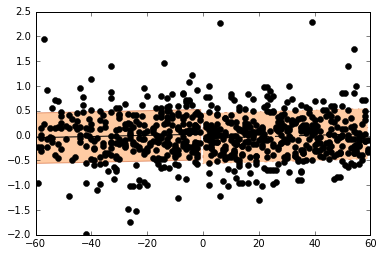

In [10]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt

GS_pre_norm=pd.DataFrame()
GS_post_norm=pd.DataFrame()
for p_ind,player_info in enumerate(player_events):
    player_tofind=player_info[0]
    date_lifeevent=pd.to_datetime(player_info[1])

    #get season URL
    date_month=date_lifeevent.month
    if date_month > 9:
        year_tofind=date_lifeevent.year+1
    else:
        year_tofind=date_lifeevent.year    
        
    #load and clean up
    days_touse=60
    gamescores_preevent = pd.read_csv(player_tofind+str(year_tofind)+'pre2mo.csv')  
    gamescores_preevent = gamescores_preevent[['Date', 'GameScore', 'Player ID']]
    gamescores_postevent = pd.read_csv(player_tofind+str(year_tofind)+'post2mo.csv')    
    gamescores_postevent = gamescores_postevent[['Date', 'GameScore', 'Player ID']]
    
    gspre_norm=pd.DataFrame()
    gspost_norm=pd.DataFrame()
    gspre_norm['GameScore'] = gamescores_preevent['GameScore']/\
                              np.mean(gamescores_preevent['GameScore'])-1
    gspost_norm['GameScore'] = gamescores_postevent['GameScore']/\
                               np.mean(gamescores_preevent['GameScore'])-1
    temp=pd.to_datetime(gamescores_preevent['Date'])-date_lifeevent
    gspre_norm['Date Difference'] = pd.Series(temp.astype('timedelta64[D]'),index=gspre_norm.index)
    
    temp=pd.to_datetime(gamescores_postevent['Date'])-date_lifeevent
    gspost_norm['Date Difference'] = pd.Series(temp.astype('timedelta64[D]'),index=gspost_norm.index)
    
    GS_pre_norm=GS_pre_norm.append(gspre_norm, ignore_index=True)
    GS_post_norm=GS_post_norm.append(gspost_norm, ignore_index=True)
    
    # minGS=np.min([np.min(gamescores_preevent_normpct),np.min(gamescores_postevent_normpct)])
    # maxGS=np.max([np.max(gamescores_preevent_normpct),np.max(gamescores_postevent_normpct)])
    # bins = np.linspace(minGS,maxGS, 20)
    # 
    # plt.hist(gamescores_preevent_normpct, bins, alpha=0.5, label='pre')
    # plt.hist(gamescores_postevent_normpct, bins, alpha=0.5, label='post')
    # plt.legend(loc='upper right')
    # plt.show()
    # 
    # [t,p]=stats.ttest_ind(gamescores_preevent_normpct, gamescores_postevent_normpct)
    # plt.title(player_tofind+' '+str(year_tofind)+' p = '+str(p)[0:4])
    
#regression up to event time
linreg=linear_model.LinearRegression()
x=GS_pre_norm['Date Difference'].values
y=GS_pre_norm['GameScore'].values
model=linreg.fit(x.reshape(-1,1),y)

#plot regression line
x_pred=range(-days_touse,0)
y_pred=model.coef_*x_pred+model.intercept_
error=np.std(GS_pre_norm['GameScore'])
plt.plot(x_pred,y_pred, 'k-')
#plot actual values
plt.plot(x.reshape(1,-1),y.reshape(1,-1),'ko')
plt.fill_between(x_pred, y_pred-error, y_pred+error,alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')

#plot post-event prediction

x=GS_post_norm['Date Difference'].values
y=GS_post_norm['GameScore'].values
model=linreg.fit(x.reshape(-1,1),y)

x_pred=range(0,days_touse)
y_pred=model.coef_*x_pred+model.intercept_
error=np.std(GS_pre_norm['GameScore'])
plt.plot(x_pred,y_pred, 'k--')

#plot actual values
x=GS_post_norm['Date Difference'].values
y=GS_post_norm['GameScore'].values
plt.plot(x.reshape(1,-1),y.reshape(1,-1),'ko')
plt.fill_between(x_pred, y_pred-error, y_pred+error,alpha=0.5, linestyle='dashdot',edgecolor='#CC4F1B', facecolor='#FF9848')
plt.show()

GS_pre_norm.to_csv('gamescores_preevent_normpct.csv')
GS_post_norm.to_csv('gamescores_postevent_normpct.csv')

In [48]:
# import matplotlib.axes as ax
import matplotlib.pyplot as plt
ax = plt.axes()
dataset=list()

for date in range(-days_touse, -10, 10):
    tempdf = GS_pre_norm.loc[(GS_pre_norm['Date Difference']>date) & 
                             (GS_pre_norm['Date Difference']<date+10)]
    if len(dataset)==0:
        dataset = [tempdf['GameScore'].values]
    else:
        dataset=dataset.append(tempdf['GameScore'].values)

    
    
ax.violinplot(dataset, positions=range(-days_touse+5,-5,10), vert=True, widths=5)
plt.show()

<type 'list'>


TypeError: object of type 'NoneType' has no len()

In [46]:
dataset=list()
type(dataset)
dataset.append(tempdf['GameScore'].values)
dataset

[array([-1.09911141,  0.48667122, -0.3557758 ,  0.88311688, -0.44497608,
        -0.11353527, -0.96716797, -0.55348443,  0.48400763, -0.05013193,
         1.40105541,  0.55672823, -0.25602888,  0.12808664,  0.16851986,
        -0.35306859, -0.01747292, -0.27467105, -0.43585526,  0.27220395,
        -0.125     , -0.88486842, -0.57142857, -0.39246468, -0.39717425,
        -0.70800628, -0.15392954, -0.49801032,  0.31053795, -0.21827561,
        -0.14929993, -0.41370671, -0.13975904, -0.7064257 , -0.00321285,
        -0.67911647, -0.58313998,  0.76102088,  0.11446249,  0.41650943,
        -0.25707547, -0.63349057])]

In [12]:
# is MPLE different from month after life event (MALE)?
#no: no significant difference between players' performance before or after (1 month or 2)
# no significant difference across all players tested

# test 2: is month before life-event (MBLE) different from player-season distribution?

#test 3: is month-month difference significantly different 
# from similar players' month-month variance?

#**what else did they want?



Series([], Name: Player ID, dtype: object)